In [46]:
# def download_data():
#     !kaggle datasets download -d "arjuntejaswi/plant-village"

In [47]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [48]:
IMAGE_SIZE=256
CHANNELS = 3
BATCH_SIZE=32
EPOCHS = 50

In [49]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [50]:
class_names = dataset.class_names
class_names

['early_blight', 'healthy', 'late_blight']

In [51]:
len(dataset)

68

In [52]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 2 2 2 2 2 0 2 0 2 2 1 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 2 0 1 0]


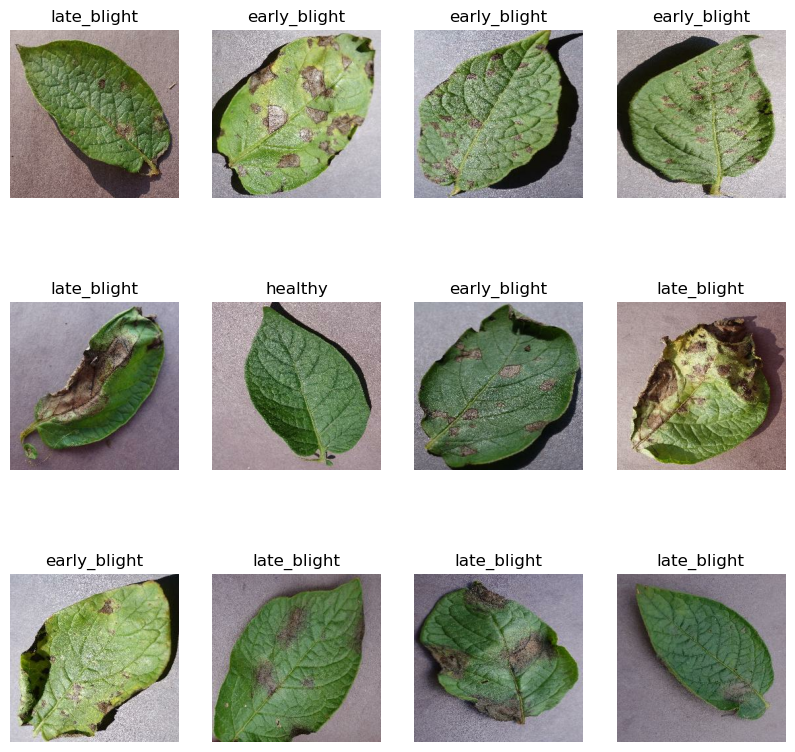

In [53]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")



In [54]:
def get_datset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert (train_split+test_split+val_split) == 1

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [55]:
train_ds, val_ds, test_ds = get_datset_partitions_tf(dataset)

In [57]:
print(len(train_ds), len(val_ds), len(test_ds))

54 6 8


In [58]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [59]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [60]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [61]:
train_ds = train_ds.map(
    lambda x,y: (data_augmentation(x,training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [66]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [67]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [69]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [70]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
54/54 [==============================] - 109s 2s/step - loss: 0.8171 - accuracy: 0.5995 - val_loss: 0.8237 - val_accuracy: 0.6250
Epoch 2/50
54/54 [==============================] - 84s 2s/step - loss: 0.5655 - accuracy: 0.7477 - val_loss: 0.4957 - val_accuracy: 0.7917
Epoch 3/50
54/54 [==============================] - 85s 2s/step - loss: 0.3419 - accuracy: 0.8600 - val_loss: 0.5389 - val_accuracy: 0.7917
Epoch 4/50
54/54 [==============================] - 95s 2s/step - loss: 0.2737 - accuracy: 0.8837 - val_loss: 0.2835 - val_accuracy: 0.8854
Epoch 5/50
54/54 [==============================] - 97s 2s/step - loss: 0.2118 - accuracy: 0.9190 - val_loss: 0.2524 - val_accuracy: 0.8802
Epoch 6/50
54/54 [==============================] - 97s 2s/step - loss: 0.1956 - accuracy: 0.9259 - val_loss: 0.2651 - val_accuracy: 0.8750
Epoch 7/50
54/54 [==============================] - 94s 2s/step - loss: 0.1420 - accuracy: 0.9416 - val_loss: 0.2115 - val_accuracy: 0.9219
Epoch 8/50
54/54 [=

KeyboardInterrupt: 